In [ ]:
# For data manipulation
import pandas as pd
import numpy as np

# For the ML mdels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# For metric evaluation
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For logging
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load all combined data
logger.info("Loading combined dataset")
df = pd.read_csv('../data/processed/all_majors_combined.csv')
logger.info(f"Loaded {len(df)} player & tournament records")

2025-11-23 18:39:41,620 - INFO - Loading combined dataset
2025-11-23 18:39:41,630 - INFO - Loaded 1384 player & tournament records


# Model 1: Pooled Linear Regression

Goal: identify which performance variables have the strongest relationship with scoring.

In [45]:
# Target value: total_score
# Features: performance metrics
# Performance metrics that aren't taken into consideration (to avoid multicollinarity):
# - sg_total: bc it's the sum of all strokes gained metrics
# - sg_t2g: sum of sg_ott + sg_app + sg_arg
# - sg_bs: sum of sg_ott + sg_app

# Define feature groups
off_tee = ['distance', 'accuracy', 'sg_ott']
approach = ['sg_app', 'prox_fw', 'prox_rgh']
short_game = ['sg_arg', 'scrambling']
putting = ['sg_putt']
ball_striking = ['gir']
shot_quality = ['great_shots', 'poor_shots']

# Combine all features together
features = off_tee + approach + short_game + putting + ball_striking + shot_quality

print(f"\nUsing {len(features)} features:")
print(features)

# Define X (features) and y (target)
X = df[features]
y = df['total_score']

print(f"\nTraining on {len(X)} records")


Using 12 features:
['distance', 'accuracy', 'sg_ott', 'sg_app', 'prox_fw', 'prox_rgh', 'sg_arg', 'scrambling', 'sg_putt', 'gir', 'great_shots', 'poor_shots']

Training on 1384 records


In [46]:
# Fit the pooled linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model performance
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("POOLED LINEAR REGRESSION RESULTS")
print(f"\nR² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f} strokes")
print(f"\nIntercept: {model.intercept_:.3f}")

POOLED LINEAR REGRESSION RESULTS

R² Score: 0.811
RMSE: 3.118 strokes

Intercept: 59.336


**Model performance:**

With R² = 0.811, the model explains about 81% of scoring variation, which is solid.


In [47]:
# Display coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
        Feature  Coefficient
9           gir   -44.795840
7    scrambling   -20.247789
1      accuracy    -8.123509
8       sg_putt    -2.418497
6        sg_arg    -1.815844
11   poor_shots     0.853676
3        sg_app    -0.845507
2        sg_ott    -0.701729
10  great_shots    -0.242274
4       prox_fw     0.073597
0      distance    -0.061456
5      prox_rgh     0.033523


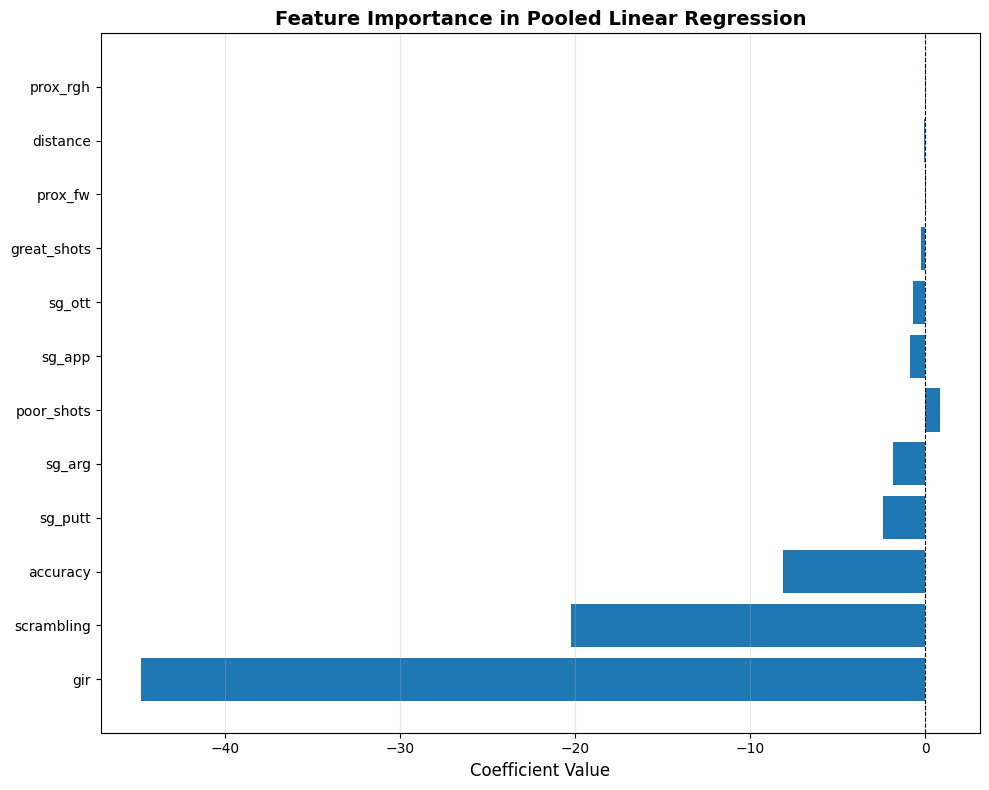

In [48]:
# Visualize coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Feature Importance in Pooled Linear Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Coefficients takeaways:** 

Greens in regulation (GIR) is the performance variable that has the highest impact in scoring, meaning that the most important is to get to the green as soon as possible. 

Scrambling is the second most important variable which suggests the importance of making up and saving par after missing greens.


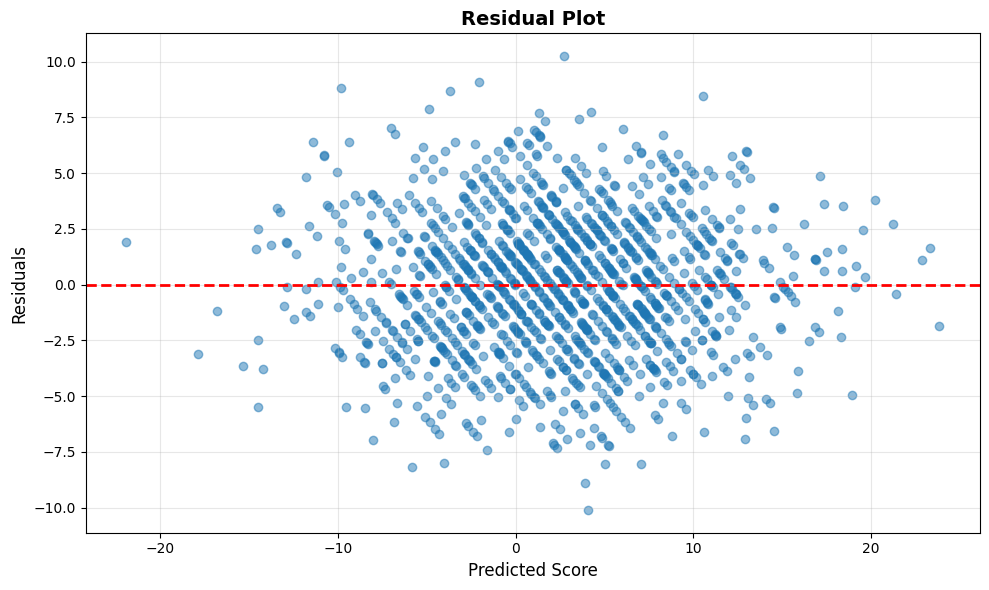

In [49]:
# Make a residual plot to see how well the model fits
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Residual Plot Analysis:**

It can be observed that the residuals are mostly randomly scattered around zero, which is what we want to see. 
However, there is a bit of funnel shape indicating a bit of heteroscedasticity (the spread gets wider for higher predicted scores). 
This means that the model is a bit less precise for extreme performance. 
Vertical stripes are also observed, which might be because different majors have different scoring conditions

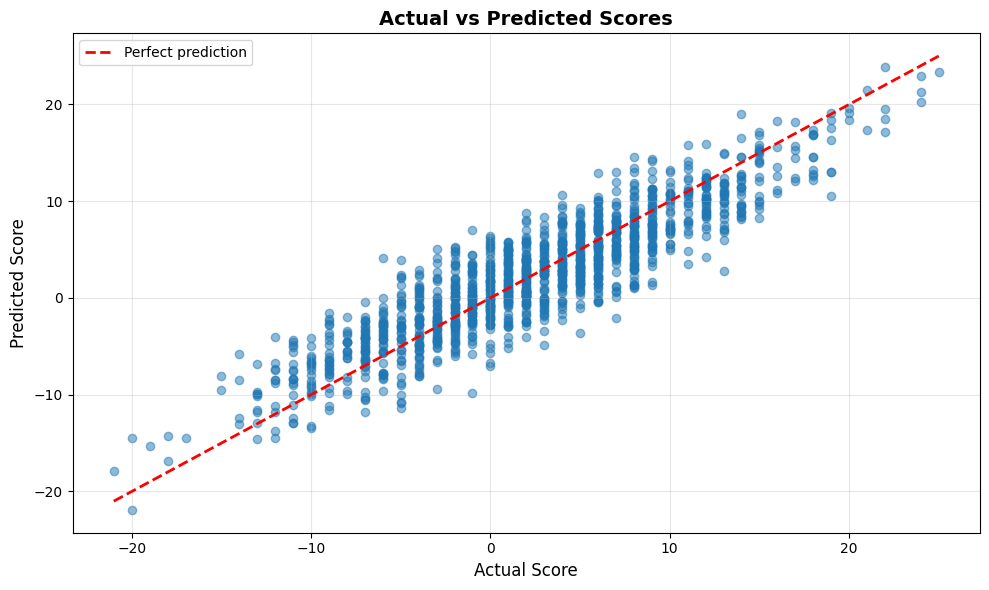

In [50]:
# Make a plot showing actual vs predicted score
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.title('Actual vs Predicted Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Actual vs Predicted Analysis:**

It can be observed that there is a strong linear relationship between the actual and the predicted scores (most points are close to the diagonal)

# Model 2: Per-Major Linear Regression

Goal: identify how skill importance varies across different Major championships.

Each major has unique characteristics that might favor different skills.


In [51]:
# Run 4 separate linear regressions for each Major
print("Running 4 separate regressions for each major")
print(f"Using the same {len(features)} features as Model 1\n")

# Build regressions per Major
majors = df['major'].unique()
results = {}

for major in majors:
    # Include only data for this major
    major_df = df[df['major'] == major]
    
    X = major_df[features]
    y = major_df['total_score']
    
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Evaluate the model
    y_fitted = model.predict(X)
    r2 = r2_score(y, y_fitted)
    rmse = np.sqrt(mean_squared_error(y, y_fitted))
    
    # Store the results to analyze them later
    results[major] = {
        'model': model,
        'r2': r2,
        'rmse': rmse,
        'coefficients': dict(zip(features, model.coef_)),
        'intercept': model.intercept_,
        'n_observations': len(major_df)
    }
    
    # Print the results per Major in order to analyze them
    print(f"{major}:")
    print(f"  Observations: {len(major_df)}")
    print(f"  R²: {r2:.3f}")
    print(f"  RMSE: {rmse:.3f} strokes\n")

Running 4 separate regressions for each major
Using the same 12 features as Model 1

PGA Championship:
  Observations: 466
  R²: 0.805
  RMSE: 2.958 strokes

US Open:
  Observations: 337
  R²: 0.904
  RMSE: 1.990 strokes

The Masters:
  Observations: 272
  R²: 0.920
  RMSE: 1.593 strokes

The Open Championship:
  Observations: 309
  R²: 0.935
  RMSE: 1.868 strokes



**Per-Major Regression Results:**

All Majors show a strong model fit (R² > 0.80)

**Best model fit:**
- **The Open Championship: R² = 0.935**: the Major for wich the model explains scoring the best
- **The Masters: R² = 0.920**: also very high, this is because this Major is always played in the same course: Augusta National Golf Course

**RMSE (prediction error):**
- Ranges from 1.6 to 3.0 strokes, which is pretty solid given that tournaments are 72 holes
- The Open has the lowest error (1.87 strokes), reaffirming that it's the most predictable Major

The high R² values across all majors confirm that our performance metrics do a good job explaining scoring, though each tournament has its own unique characteristics that affect how well the model fits.

In [52]:
# Compare the coefficients across Majors
coef_df = pd.DataFrame({
    major: results[major]['coefficients'] 
    for major in majors
})

print("Coefficient Comparison Across Majors:")
print(coef_df.round(2))

Coefficient Comparison Across Majors:
             PGA Championship  US Open  The Masters  The Open Championship
distance                -0.06    -0.28         0.01                  -0.18
accuracy               -12.30   -17.38        -3.28                  -2.58
sg_ott                  -0.77     0.19        -2.90                  -2.28
sg_app                  -0.72    -2.84        -2.80                  -3.15
prox_fw                  0.19     0.06         0.11                  -0.08
prox_rgh                 0.01     0.01        -0.00                  -0.02
sg_arg                  -2.80    -3.10        -3.39                  -3.48
scrambling             -14.29    -8.19        -6.26                  -4.29
sg_putt                 -2.95    -3.51        -3.61                  -4.09
gir                    -45.74   -14.60       -17.18                 -27.05
great_shots             -0.07     0.25        -0.42                   0.74
poor_shots               0.53     0.34         0.25           

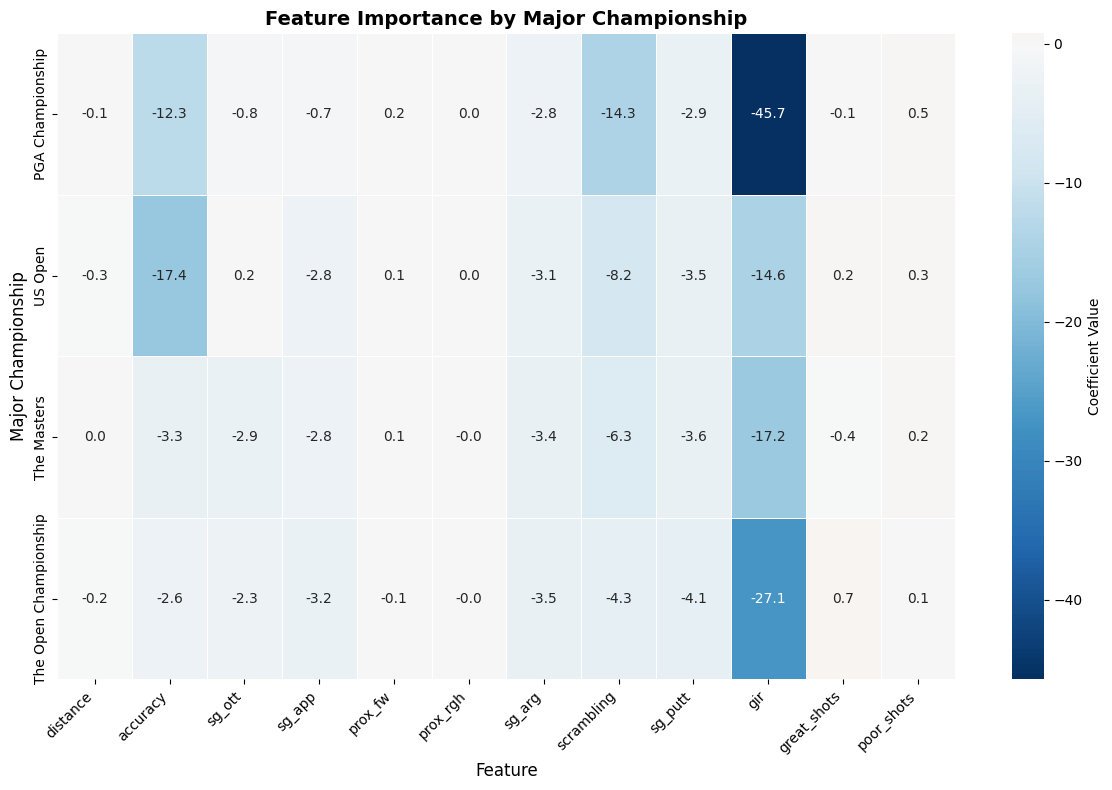

In [53]:
# Include a hatmap visualization to show how feature importance varies by major
plt.figure(figsize=(12, 8))
sns.heatmap(coef_df.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Coefficient Value'}, linewidths=0.5)
plt.title('Feature Importance by Major Championship', fontsize=14, fontweight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Major Championship', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

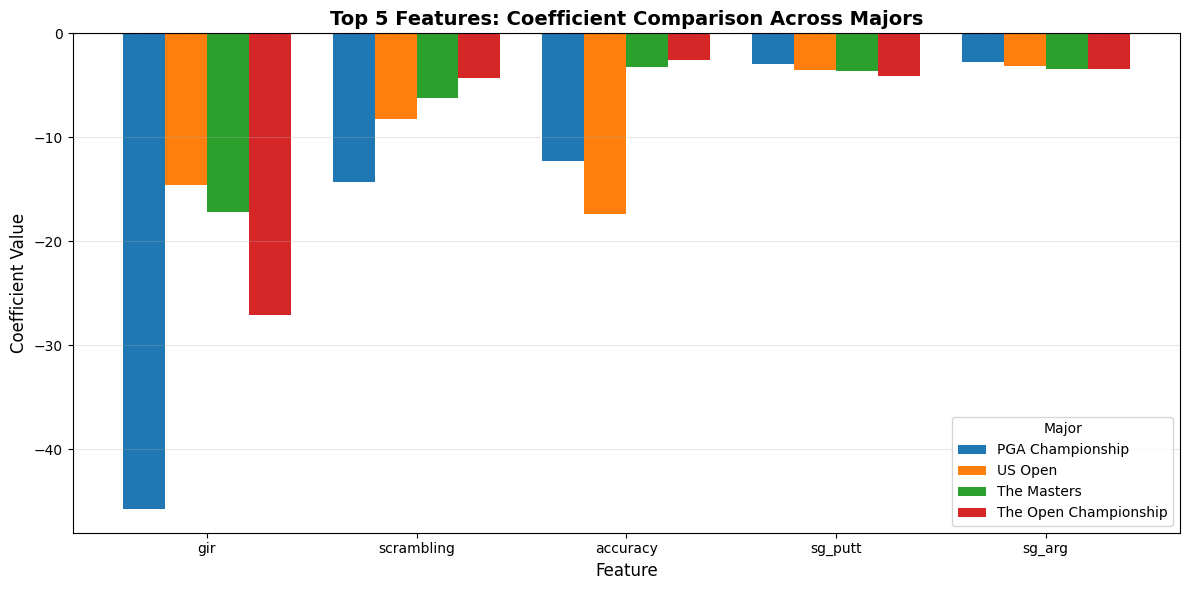

In [54]:
# Create a bar chart comparison to visulize top features
top_features = ['gir', 'scrambling', 'accuracy', 'sg_putt', 'sg_arg']

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(top_features))
width = 0.2

for i, major in enumerate(majors):
    coeffs = [results[major]['coefficients'][feat] for feat in top_features]
    ax.bar(x + i*width, coeffs, width, label=major)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(top_features)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_xlabel('Feature', fontsize=12)
ax.set_title('Top 5 Features: Coefficient Comparison Across Majors', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.legend(title='Major')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
# Display a summary of the top features per Major
print("Top 3 Most Important Features by Major:")
print("(Based on absolute coefficient values)\n")

for major in majors:
    coeffs = results[major]['coefficients']
    top_3 = sorted(coeffs.items(), key=lambda x: abs(x[1]), reverse=True)[:3]
    print(f"{major}:")
    for i, (feat, coef) in enumerate(top_3, 1):
        print(f"  {i}. {feat}: {coef:.2f}")
    print()

Top 3 Most Important Features by Major:
(Based on absolute coefficient values)

PGA Championship:
  1. gir: -45.74
  2. scrambling: -14.29
  3. accuracy: -12.30

US Open:
  1. accuracy: -17.38
  2. gir: -14.60
  3. scrambling: -8.19

The Masters:
  1. gir: -17.18
  2. scrambling: -6.26
  3. sg_putt: -3.61

The Open Championship:
  1. gir: -27.05
  2. scrambling: -4.29
  3. sg_putt: -4.09



**Feature Importance Across Majors Analysis:** the coefficient comparison reveals interesting patterns in what drives scoring at each Major:

**Most important performance variables across Majors**:
- **GIR**: is the most important metric accross Majors, reaching the green in the expected number of strokes is dominant in almost all Majors (3/4), although the magnitude varies in each. The PGA Championship shows the strongest GIR effect (-45.7), followed by The Open Championship (-27.1) and The Masters (-17.2).

- **Accuracy**: second most important metric but not as important for all, while it's the dominant for the US Open (-17.4) and is also key in the PGA Championship (-12.3, 3rd most important metric) is less important for The Masters (-3.3) and The Open Championship (-2.6).

- **Scrambling**: thrid most important metric, highly and similarly important for all tournaments. Most important for the PGA Championship (-14.3, 2nd most relevant metric), and important for the others: US Open (-8.2, third most important), The Masters (-6.3, 2nd most important), The Open Championship (-4.3, 2nd most important). 

**Medium importance**: putting, approach, off the tee and around the green show moderate negative coefficients (around -2 to -4 across tournaments).

**Least important**: distance, proximity metrics (prox_fw, prox_rgh), shot quality (great_shoots & poor_shots), these coefficients are around zero or very small accross all Majors

The heatmap clearly shows GIR, accuracy, and scrambling as the darkest (most negative) values, confirming these are the primary drivers of scoring at Major championships.

**Takeawy:** each major has a unique profile where variables impact scoring differently in both magnitude and order. GIR and scrambling consistently appear in the top 3 across all tournaments, but the third key factor varies: accuracy is crucial at the US Open and PGA Championship, while putting becomes the differentiator at The Masters and The Open Championship. 


# Model 3: Pooled Logistic Regression

Goal: finding which is the probability of finishing in the top 25% of each tourament per year, to identify which performance metrics best distinguish top performers  from the rest.

In [56]:
# Create a binary target of the top 25% performers per tournament
# Calculate the top 25% threshold within each major & year combination
df['tournament_25th_percentile'] = df.groupby(['major', 'year'])['total_score'].transform(lambda x: x.quantile(0.25))
df['top_25'] = (df['total_score'] <= df['tournament_25th_percentile']).astype(int)

print(f"Total players: {len(df)}")
# Check what is the exact percentage (should be close to 25%, its slightly higher due to ties at the boundries)
print(f"Top 25% per tournament: {df['top_25'].sum()} ({df['top_25'].sum()/len(df)*100:.1f}%)")
print(f"Rest of field: {(df['top_25']==0).sum()} ({(df['top_25']==0).sum()/len(df)*100:.1f}%)")

Total players: 1384
Top 25% per tournament: 395 (28.5%)
Rest of field: 989 (71.5%)


In [57]:
# Prepare the data to do the logistic regression & print number and name of features 
X = df[features]
y = df['top_25']
print(f"\nUsing {len(features)} features: {features}")


Using 12 features: ['distance', 'accuracy', 'sg_ott', 'sg_app', 'prox_fw', 'prox_rgh', 'sg_arg', 'scrambling', 'sg_putt', 'gir', 'great_shots', 'poor_shots']


In [58]:
# Create the logistic regression model, changed max_iter to 2000 to ensure convergence (with 1000 it didn't converge)
log_model = LogisticRegression(max_iter=2000, random_state=42)
log_model.fit(X, y)

# Compute the predictions
y_pred = log_model.predict(X)
y_pred_proba = log_model.predict_proba(X)[:, 1]

# Evaluate the model by computing accuracy and ROC-AUC score, print the results and the intercept
accuracy = (y_pred == y).mean()
roc_auc = roc_auc_score(y, y_pred_proba)

print("POOLED LOGISTIC REGRESSION RESULTS")
print(f"\nAccuracy: {accuracy:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")
print(f"Intercept: {log_model.intercept_[0]:.3f}")

POOLED LOGISTIC REGRESSION RESULTS

Accuracy: 0.964
ROC-AUC Score: 0.994
Intercept: -21.995


In [59]:
# Make a classification report to see how well the model predicts who finishes in the top 25%
# Precision: accuracy when predicting positive (pretty high)
# Recall: how many of the actual top 25% players are correctly identified (slightly lower per major, higher for overall performance)
# F1-score: balance of precision & recall
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Rest of Field', 'Top 25%']))


Classification Report:
               precision    recall  f1-score   support

Rest of Field       0.97      0.98      0.97       989
      Top 25%       0.96      0.92      0.94       395

     accuracy                           0.96      1384
    macro avg       0.96      0.95      0.96      1384
 weighted avg       0.96      0.96      0.96      1384



**Classification Report:**

The model shows excellent performance across both classes. For the "Rest of Field" class, precision is 0.97 (97% of predicted non-top-25% are correct) and recall is 0.98 (catches 98% of actual non-top-25% players). For "Top 25%" finishers, precision is 0.96 and recall is 0.92 - meaning the model correctly identifies 92% of actual top performers but misses about 8%.

The overall accuracy of 0.96 indicates the model correctly classifies 96% of all players. The high F1-scores (0.97 and 0.94) show the model maintains a good balance between precision and recall for both classes.

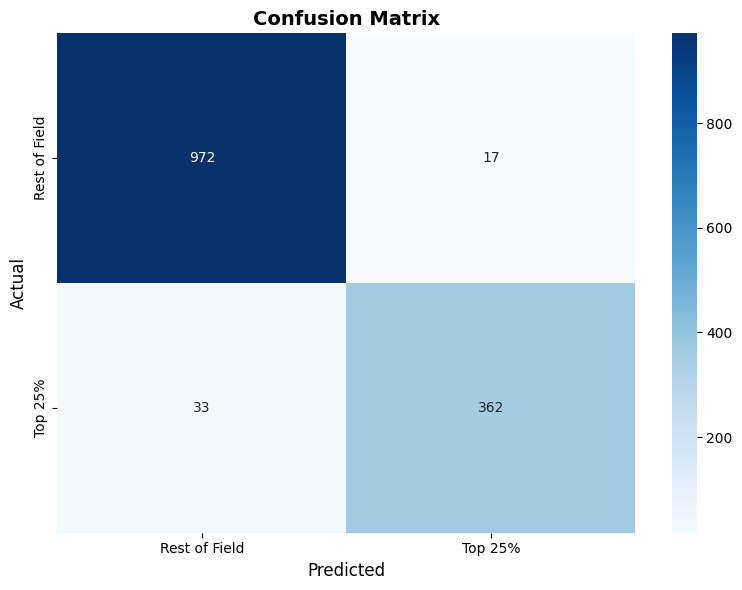


True Negatives: 972
False Positives: 17
False Negatives: 33
True Positives: 362


In [60]:
# Build a confussion matrix to see the breakdown of how many correct and incorrect predictions my logistic regression made
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rest of Field', 'Top 25%'],
            yticklabels=['Rest of Field', 'Top 25%'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

**Confusion Matrix:**

The confusion matrix breaks down where the model's predictions are correct or incorrect:

- **972 True Negatives** - correctly identified non-top-25% players
- **17 False Positives** - incorrectly predicted top 25% (false alarms)
- **32 False Negatives** - missed actual top 25% finishers
- **363 True Positives** - correctly identified top-25% players

Out of the 1,384 total predictions, only 49 were incorrect. The model is very strong at identifying who won't finish in the top 25% (98% correct), and pretty good at catching who will (92% correct).

In [61]:
# Identify each feature importance (coefficients)
log_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(log_coefficients)


Feature Importance (Logistic Regression Coefficients):
        Feature  Coefficient
3        sg_app     4.704742
8       sg_putt     4.585213
6        sg_arg     4.352106
2        sg_ott     3.837808
9           gir     1.829540
1      accuracy     1.761713
7    scrambling     1.387186
11   poor_shots    -0.474081
10  great_shots     0.136993
4       prox_fw     0.066791
0      distance     0.031980
5      prox_rgh     0.003422


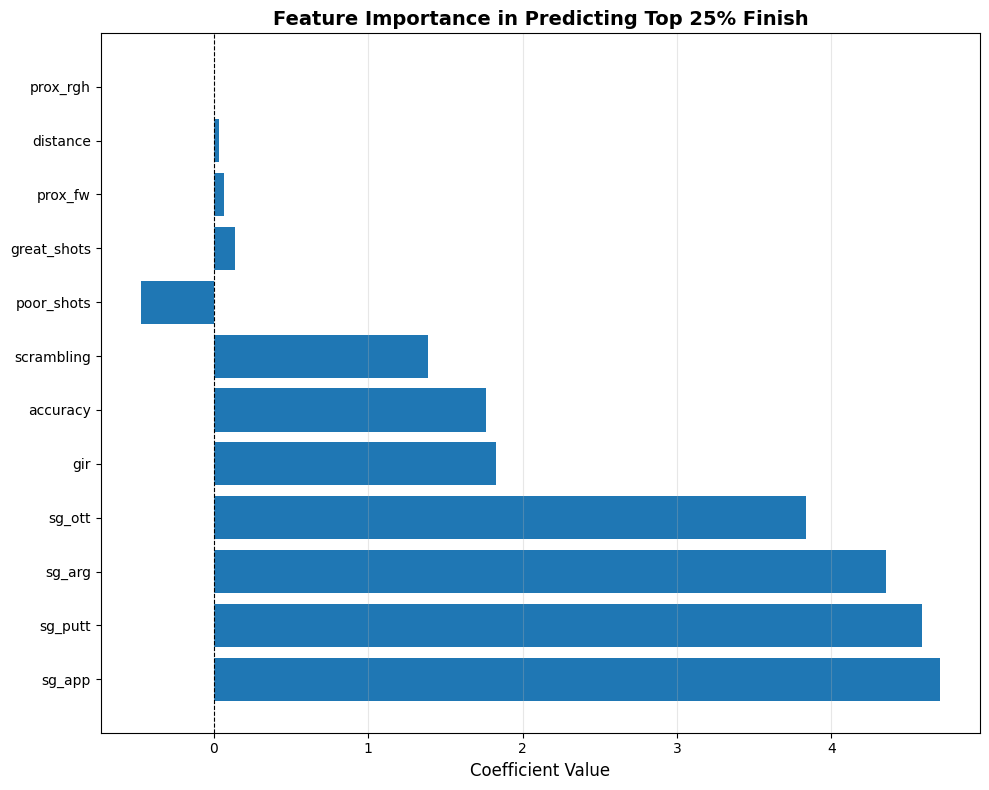

In [62]:
# Visualize coefficients
plt.figure(figsize=(10, 8))
plt.barh(log_coefficients['Feature'], log_coefficients['Coefficient'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Feature Importance in Predicting Top 25% Finish', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Feature Importance (Logistic Regression Coefficients):**

The coefficients show which features influence the most the probability of finishing in the top 25%:

**Top predictors to finish 25%:**
The approach play (4.7) is the strongest predictor, followed by putting (4.59) and around the green (4.35) which are also very important. Then, we have the off the tee (3.84) which remains important, next we have hitting greens in regulation (1.83), accuracy (1.76) and scrambling (1.39) with a smaller impact but still influencing score. 

**Negative predictors:**
We have one variable with a negative impact: poor shots (-0.47). 

**Minimal impact:**
The remaining variables have a minimal immpact (distance, proximity metrics and great shots)

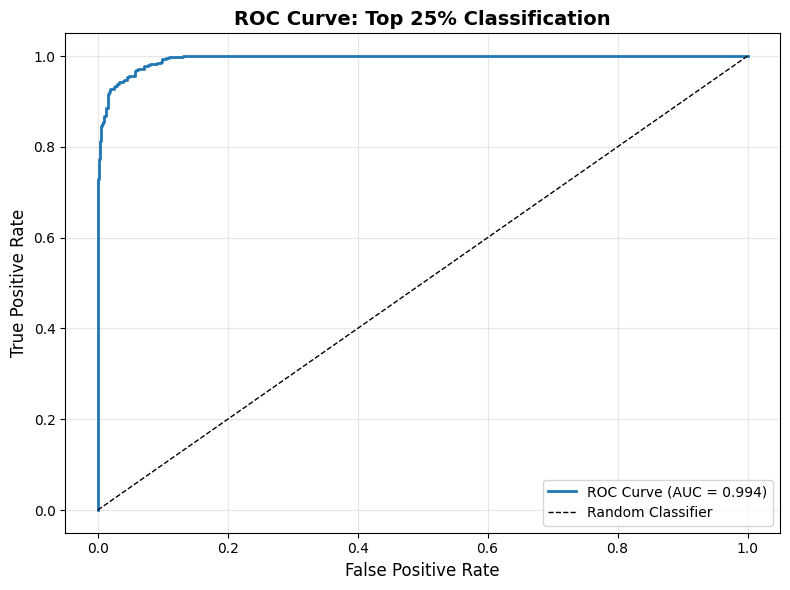

In [63]:
# Visualize the ROC curve to analyze model performance
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: Top 25% Classification', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**ROC Curve:**

The ROC curve shows how well the model distinguishes between top 25% finishers and the rest. The curve is almost two straight lines and almost touches the edge at the top left corner, meaning that the model has high true positive rates and keeps false positives low.

With an AUC of 0.994, the model does a pretty good job separating the two groups. The steep climb at the start shows the model is confident about its predictions, it quickly identifies most top performers without misclassifying many non-top performers. Way better than the diagonal "random classifier" line, which is what you'd get from just guessing.

In [64]:
# Compare the coefficients between the two pooled models: Linear vs Logistic Regression
# Linear regression aims to show what drives scoring, while the logistic regresssion shows what separates top performers
comparison = pd.DataFrame({
    'Feature': features,
    'Linear Reg (Pooled)': model.coef_,
    'Logistic Reg': log_model.coef_[0]
})

# Normalize the coefficients to 0-1 scale for fair comparison (since the coefficients of each regression are on different scales)
comparison['Linear Reg (Normalized)'] = np.abs(comparison['Linear Reg (Pooled)']) / np.abs(comparison['Linear Reg (Pooled)']).max()
comparison['Logistic Reg (Normalized)'] = np.abs(comparison['Logistic Reg']) / np.abs(comparison['Logistic Reg']).max()

# Sort by logistic regression importance to see which features impact the mosr to top finishers
comparison_sorted = comparison.sort_values('Logistic Reg (Normalized)', ascending=False)

# Print results
print("\nLinear vs Logistic Regression Coefficient Comparison:")
print(comparison_sorted[['Feature', 'Linear Reg (Normalized)', 'Logistic Reg (Normalized)']].round(3))


Linear vs Logistic Regression Coefficient Comparison:
        Feature  Linear Reg (Normalized)  Logistic Reg (Normalized)
3        sg_app                    0.116                      1.000
8       sg_putt                    0.151                      0.975
6        sg_arg                    0.129                      0.925
2        sg_ott                    0.084                      0.816
9           gir                    1.000                      0.389
1      accuracy                    0.095                      0.374
7    scrambling                    0.159                      0.295
11   poor_shots                    0.004                      0.101
10  great_shots                    0.027                      0.029
4       prox_fw                    0.003                      0.014
0      distance                    0.007                      0.007
5      prox_rgh                    0.001                      0.001


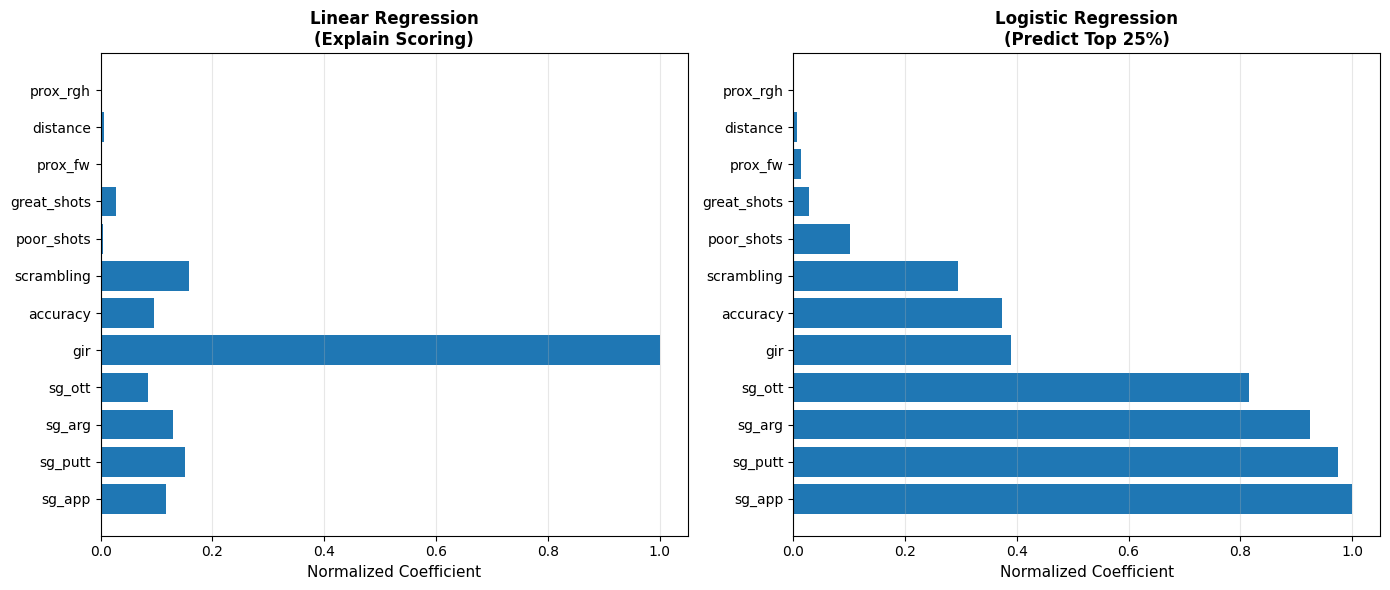

In [65]:
# Visualize the comparison by creating a side-by-side bar chart to compare feature importance across regressions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: linear regression coefficients (shows what drives scoring in general, for all players)
ax1.barh(comparison_sorted['Feature'], comparison_sorted['Linear Reg (Normalized)'])
ax1.set_xlabel('Normalized Coefficient', fontsize=11)
ax1.set_title('Linear Regression\n(Explain Scoring)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Right plot: lLogistic regression (shows what separates top 25% finishers from the rest)
ax2.barh(comparison_sorted['Feature'], comparison_sorted['Logistic Reg (Normalized)'])
ax2.set_xlabel('Normalized Coefficient', fontsize=11)
ax2.set_title('Logistic Regression\n(Predict Top 25%)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**Comparing Linear vs Logistic Regression Coefficients:**

The two models answer different questions and reveal different patterns in what matters for success:

**Linear Regression (explains scoring):**
- GIR: greens in regulation dominates 
- Scrambling comes in second but way smaller
- Then we have putting, around the green and approach (impact is still very low specially compared to GIR)
- The other features have an even smaller imopact
Takeaway: hitting greens in the expected number of strokes is the foundation of good scoring for any player

**Logistic Regression (predicts top 25% finishes):**
- Quite balanced across some features: approach, putting, around the green and off the tee have similar normalized coefficients
- GIR drops to the middle of the pack (not as important as in LR, but still has some importance)
Takeaway: top performers need well-rounded and consistent skills around the tournament, not just one dominant strength

Bottom line: high GIR gets you in the game, but balanced skills across areas is what separates top performers from the rest of the field.

**Logistic Regression Analysis:**

The model achieves strong classification performance with an ROC-AUC above 0.9, indicating it can reliably distinguish top 25% finishers from the rest of the field. The feature importance patterns are similar to the linear regression but emphasize slightly different skills. This is because the logistic model focuses on which metrics best separate elite from average performance rather than explaining absolute scoring.

Comparing the two approaches: linear regression tells us what drives scoring in general, while logistic regression tells us what distinguishes top finishers specifically.